# Pesos Espaciales

Los **pesos espaciales** capturan el conocimiento sobre cómo se relacionan espacialmente las unidades de observación. Preguntas comunes como:

- ¿Qué barrios colindan con el mío?
- ¿Cuántas gasolineras hay a menos de 5 km de mi auto averiado?

son ejemplos de relaciones espaciales que dependen de la proximidad o adyacencia geográfica.

Para incorporar estas relaciones en el análisis estadístico, es necesario calcularlas entre todos los pares de observaciones. Esto da lugar a una **topología**, es decir, una estructura matemática que describe la conectividad espacial entre unidades. Las **matrices de pesos espaciales** permiten representar esta topología, integrando todas las observaciones dentro de un mismo espacio de análisis.


In [1]:
import contextily
import geopandas
import rioxarray
import seaborn
import pandas
import numpy
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
#from pysal.lib import cg as geometry

Los **pesos espaciales** son fundamentales en la ciencia de datos geográficos, ya que permiten representar relaciones espaciales entre observaciones.

En este capítulo se abordan distintas formas de construir estos pesos, diferenciando entre:

- Pesos basados en **adyacencia o contigüidad**.
- Pesos basados en **distancia**.
- Pesos **híbridos**, que combinan varios criterios espaciales.

Estos conceptos se ilustran usando la clase de pesos espaciales del paquete `pysal`, disponible en su submódulo `weights`, que ofrece múltiples métodos para trabajar con estas estructuras.


In [2]:
from libpysal import weights

También se exploran las funcionalidades basadas en **operaciones de conjuntos**, que permiten construir pesos espaciales combinando relaciones.

Además, se revisan los **formatos comunes de archivo** para almacenar estos pesos y se incluyen visualizaciones que ayudan a comprender de forma más intuitiva estas estructuras abstractas.

### Conectividad en el espacio

En el caso de series de tiempo, la idea de una variable rezagada no es ambigua, en el espacio las cosas pueden complicarse. 

En lo siguiente se asumen que las observaciones están organizadas en **unidades espaciales**, que pueden ser puntos en un *grid* regular o irregular, o regiones en un mapa. 

#### Vecinos en el espacio

El concepto de dependencia espacial implica la necesidad de determinar qué otras unidades en el sistema espacial tienen influencia en la unidad particular que se está considerando. Formalmente, esto se expresa en los conceptos de la topología como [vecindad](https://es.wikipedia.org/wiki/Entorno_(matem%C3%A1tica)) y vecino más cercano.


Consideremos un sistema $S$ de $N$ unidades espaciales, etiquetadas $i = 1,2,\ldots N$, y una variable $x$ observada para cada una de estas unidades espaciales. El conjunto de vecinos $J$ para la unidad espacial $i$, para el cual:

$$
P[x_i|x] = P[x_i|x_J] 
$$

donde $x_J$ es el vector de observaciones para $x_j \forall j \in J$, y $x$ es el vector que tiene todos los valores del sistema. De forma menos estricta, el conjunto de vecinos $j$ para la unidad espacial $i$ puede ser:

$$
\{j|P[x_i] \neq P[x_i|x_j]\}
$$

es decir, como las posiciones para las que la probabilidad marginal condicional para $x_i$ no es igual a la probabilidad marginal no condicional. Note que hasta el momento no se ha mencionado nada respecto a las posiciones relativas de las unidades espaciales, solo la influencia a través de probabilidades [condicionales](https://es.wikipedia.org/wiki/Probabilidad_condicionada). 



Para introducir el **aspecto espacial** en estas definiciones de vecinos, se tiene esta definición:

$$
\{j|P[x_i] \neq P[x_i|x_j],\quad d_{ij}< \epsilon_i\}
$$


donde $d_{ij}$ es una medida de distancia entre $i$ y $j$ en un espacio apropiadamente estructurado (espacios euclideanos, espacios métricos, etc), y $\epsilon_i$ es un punto de corte crítico para cada unidad espacial $i$, que puede ser el mismo para todas las unidades espaciales. 

Esta definción alternativa de vecindad introduce más estructura en el conjunto de datos espaciales, combinando una noción de dependencia estadística (relacionando magnitudes) con la noción de espacio (distancia y posición relativa).

El conjunto de vecinos espaciales puede representarse en una estructura de grafo con una matriz de conectividad asociada. 

## Contiguidad espacial

Dos objetos espaciales son **contiguos** si comparten un borde común. Aunque esto parece simple, en la práctica puede ser más complejo, ya que existen distintas formas de definir esa "frontera compartida".

Por ejemplo, una cuadrícula de 3x3 permite ilustrar las distintas maneras en que las unidades pueden estar conectadas espacialmente.


In [3]:
# Importamos las bibliotecas necesarias
import numpy
import geopandas
from shapely.geometry import Polygon

# Creamos una secuencia de 3 valores: [0, 1, 2]
l = numpy.arange(3)

# Generamos una malla de coordenadas (una cuadrícula de puntos) usando meshgrid
# xs y ys serán matrices 3x3 con coordenadas X e Y respectivamente
xs, ys = numpy.meshgrid(l, l)

# Inicializamos una lista vacía donde se almacenarán los polígonos
polys = []

# Iteramos sobre cada punto (x, y) de la cuadrícula
# flatten() convierte las matrices 2D en arreglos 1D para que podamos iterar más fácilmente
for x, y in zip(xs.flatten(), ys.flatten()):
    # Creamos un polígono cuadrado unitario con vértices en sentido antihorario
    # El polígono va desde (x, y) hasta (x+1, y+1), formando un cuadrado de 1x1
    poly = Polygon([(x, y), (x + 1, y), (x + 1, y + 1), (x, y + 1)])
    
    # Agregamos el polígono a la lista
    polys.append(poly)

# Convertimos la lista de polígonos en una GeoSeries de geopandas
polys = geopandas.GeoSeries(polys)

# Creamos un GeoDataFrame con dos columnas:
# - "geometry": contiene los polígonos
# - "id": etiquetas con el formato 'P-00', 'P-01', ..., 'P-08'
gdf = geopandas.GeoDataFrame(
    {
        "geometry": polys,
        "id": ["P-%s" % str(i).zfill(2) for i in range(len(polys))],
    }
)


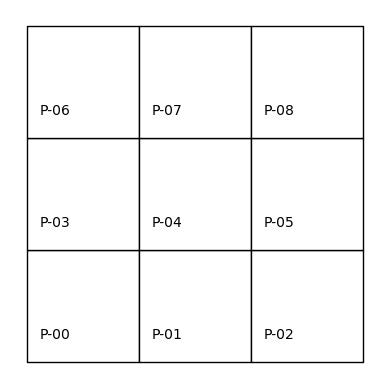

In [4]:
# Trazamos (plot) el GeoDataFrame `gdf`
# Cada celda se dibuja con borde negro (edgecolor="k") y relleno blanco (facecolor="w")
ax = gdf.plot(facecolor="w", edgecolor="k")

# Iteramos sobre cada celda del grid para añadir texto dentro de ella
# Usamos las coordenadas del centroide de cada polígono, ajustadas un poco (-0.25) para mejor alineación visual
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],  # Coordenada x del centroide, desplazada
    [p.centroid.y - 0.25 for p in polys],  # Coordenada y del centroide, desplazada
    [i for i in gdf["id"]],                # Identificador de cada celda, ej. "P-00"
):
    # Dibujamos el texto `t` en la posición (x, y)
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",      # Centra el texto verticalmente
        horizontalalignment="center",    # Centra el texto horizontalmente
    )

# Ocultamos los ejes del gráfico para una presentación más limpia
ax.set_axis_off()

# Mostramos el gráfico
plt.show()


### Contigüidad tipo Rook

Una forma común de definir la **adyacencia espacial** es mediante la analogía con los movimientos del ajedrez. En la **contigüidad tipo Rook**, dos polígonos son vecinos si comparten un **borde** (no solo un vértice).

Aplicando esta regla en una cuadrícula, es posible identificar los vecinos de cada celda y construir una estructura que modele estas relaciones espaciales.

In [5]:
# Construye una matriz de contigüidad tipo "Rook" (torre del ajedrez)
# a partir de un GeoDataFrame (gdf) que contiene una cuadrícula regular de 3x3 celdas

wr = weights.contiguity.Rook.from_dataframe(gdf, use_index=True)


Observamos que el objeto `w` se construye siguiendo un patrón común en la biblioteca: primero se define el tipo de vecindad deseado (por ejemplo, `weights.contiguity.Rook`), y luego se utiliza un método constructor como `from_dataframe()`.

El resultado puede visualizarse sobre la misma cuadrícula de polígonos etiquetados, donde las líneas punteadas rojas indican las conexiones (aristas) entre centroides de polígonos vecinos, como se muestra en la siguiente figura.


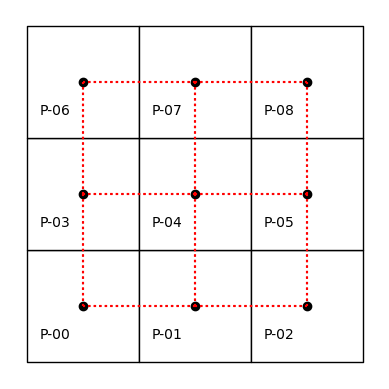

In [6]:
# Configura una figura y un solo eje (ax), asegurando que tenga proporciones iguales
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))

# Dibuja la cuadrícula de polígonos sobre el eje definido
# Cada celda se representa con borde negro (edgecolor="k") y relleno blanco (facecolor="w")
gdf.plot(facecolor="w", edgecolor="k", ax=ax)

# Recorre cada celda del grid para agregar su identificador como texto
# Se usan las coordenadas del centroide de cada polígono, ligeramente desplazadas para centrado visual
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],  # Coordenadas x de los centroides desplazadas
    [p.centroid.y - 0.25 for p in polys],  # Coordenadas y de los centroides desplazadas
    [i for i in gdf["id"]],                # Identificadores de cada celda, ej. "P-00"
):
    # Agrega el texto sobre la figura
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",      # Centra el texto verticalmente
        horizontalalignment="center",    # Centra el texto horizontalmente
    )

# Dibuja la conectividad espacial definida por la matriz de pesos `wr`
# Se visualiza como líneas punteadas rojas entre los centroides de polígonos vecinos
wr.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)

# Oculta los ejes de la figura para una visualización más limpia
ax.set_axis_off()


El atributo `neighbors` en objetos de `pysal` guarda las relaciones de vecindad como un diccionario: la **clave** representa una observación, y su **valor** es la lista de vecinos.

Este formato es eficiente computacionalmente, ya que aprovecha la **sparsidad** de las matrices de pesos espaciales, almacenando solo los valores distintos de cero.


In [7]:
wr.neighbors

{0: [1, 3],
 1: [0, 2, 4],
 2: [1, 5],
 3: [0, 4, 6],
 4: [1, 3, 5, 7],
 5: [8, 2, 4],
 6: [3, 7],
 7: [8, 4, 6],
 8: [5, 7]}

Saber que el polígono 0 solo tiene como vecinos a los polígonos 1 y 3 implica que los demás (2, 4, 5, 6, 7 y 8) **no son vecinos** bajo la contigüidad tipo Rook.

Por ello, no se almacena información sobre no-vecinos, lo que **optimiza el uso de memoria**. Si fuera necesario, aún es posible construir una **matriz completa** que incluya todas las relaciones.


In [8]:
pandas.DataFrame(*wr.full()).astype(int)

0  1  2  3  4  5  6  7  8
0  0  1  0  1  0  0  0  0  0
1  1  0  1  0  1  0  0  0  0
2  0  1  0  0  0  1  0  0  0
3  1  0  0  0  1  0  1  0  0
4  0  1  0  1  0  1  0  1  0
5  0  0  1  0  1  0  0  0  1
6  0  0  0  1  0  0  0  1  0
7  0  0  0  0  1  0  1  0  1
8  0  0  0  0  0  1  0  1  0

En la matriz de contigüidad, la mayoría de las entradas son **ceros**. De los 81 posibles enlaces (9×9), solo **24** son valores diferentes de cero, lo que resalta su naturaleza **dispersa**.


In [9]:
wr.nonzero

24

Las **representaciones dispersas** de pesos espaciales permiten ahorrar memoria sin perder información, ya que solo almacenan los valores distintos de cero.

En una cuadrícula 3x3, la matriz de pesos tendría 9 filas y 9 columnas. A diferencia del tiempo, donde las relaciones suelen ser unidireccionales, las relaciones espaciales son **bidireccionales** y el orden de las observaciones en la matriz es **arbitrario**.

Las matrices de pesos espaciales son similares a las **matrices de adyacencia** en teoría de grafos, donde cada observación es un **nodo** y los pesos representan las conexiones (**arcos**) entre ellos. Este paralelismo permite aplicar conceptos de grafos en ciencia de datos geográficos, aunque también se requieren técnicas especializadas para tratar particularidades del espacio.

Respecto a la **contigüidad tipo Rook**, aunque polígonos como el 0 y el 5 comparten un **vértice**, no son considerados vecinos porque no comparten un **borde**. Para incluir conexiones basadas en vértices, se puede usar la **contigüidad tipo Queen**, más flexible, que considera vecinos a los polígonos que comparten vértices o bordes.

### Contigüidad tipo Rook

In [10]:
# Construye una matriz de contigüidad tipo "Queen" (reina del ajedrez)
# a partir de un GeoDataFrame (gdf) que contiene una cuadrícula regular de 3x3 celdas

wq = weights.contiguity.Queen.from_dataframe(gdf,use_index=True)

# Visualiza la estructura de vecinos (neighbors) del objeto wq
# Esto devuelve un diccionario donde:
# - Las claves son los identificadores de las unidades espaciales
# - Los valores son listas de los vecinos directos de cada unidad
wq.neighbors


{0: [1, 3, 4],
 1: [0, 2, 3, 4, 5],
 2: [1, 4, 5],
 3: [0, 1, 4, 6, 7],
 4: [0, 1, 2, 3, 5, 6, 7, 8],
 5: [1, 2, 4, 7, 8],
 6: [3, 4, 7],
 7: [3, 4, 5, 6, 8],
 8: [4, 5, 7]}

Además de expresar las relaciones de vecindad en forma de listas o matrices, también es posible **visualizar el grafo**, como se muestra en la siguiente figura.

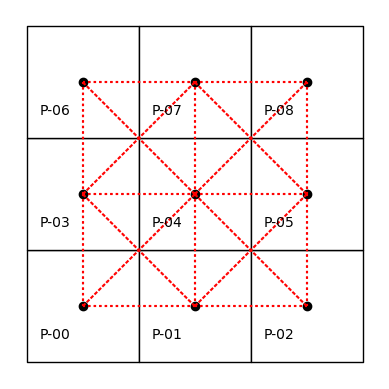

In [11]:
# Configura la figura y un eje (ax) con proporciones iguales
# Esto asegura que los polígonos no se deformen en el gráfico
f, ax = plt.subplots(1, 1, subplot_kw=dict(aspect="equal"))

# Dibuja el GeoDataFrame (gdf) que contiene la cuadrícula de polígonos
# Cada celda se muestra con borde negro (edgecolor="k") y fondo blanco (facecolor="w")
gdf.plot(facecolor="w", edgecolor="k", ax=ax)

# Itera sobre cada polígono para agregar una etiqueta de texto en el centro
# Se usan las coordenadas de los centroides, desplazadas -0.25 unidades para mejor alineación
for x, y, t in zip(
    [p.centroid.x - 0.25 for p in polys],  # Coordenadas X de los centroides desplazadas
    [p.centroid.y - 0.25 for p in polys],  # Coordenadas Y de los centroides desplazadas
    [i for i in gdf["id"]],                # Etiquetas o IDs de cada polígono, como 'P-00', 'P-01', etc.
):
    # Añade el texto (ID) en la posición (x, y)
    plt.text(
        x,
        y,
        t,
        verticalalignment="center",      # Centrado vertical
        horizontalalignment="center",    # Centrado horizontal
    )

# Dibuja las relaciones de conectividad espacial basadas en la matriz Queen
# Se trazan líneas punteadas rojas (color="r", linestyle=":") entre los polígonos que son vecinos
wq.plot(gdf, edge_kws=dict(color="r", linestyle=":"), ax=ax)

# Oculta los ejes del gráfico para una visualización más limpia y estética
ax.set_axis_off()


Usar **Queen** en lugar de **Rook** permite considerar como vecinos a los polígonos que comparten un **vértice**. Por ejemplo, el polígono 0 ahora también tiene como vecino al 4, además del 1 y el 3.

Al igual que el diccionario `neighbors` codifica las relaciones espaciales, el diccionario `weights` indica la **fuerza del vínculo** entre cada unidad y sus vecinos. En el caso de pesos por contigüidad, esta matriz suele ser **binaria**, indicando simplemente si hay o no una conexión.

En objetos `W` de `pysal`, los valores de los pesos se almacenan en el atributo `weights`.


In [12]:
wq.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0]}

El atributo `weights`, al igual que `neighbors`, es un **diccionario** que solo guarda los **pesos distintos de cero**. Aunque en pesos por contigüidad todos los vecinos suelen tener el mismo valor, es clave que los **pesos y vecinos estén alineados**: el primer vecino tiene asignado el primer peso, y así sucesivamente.

Esto será especialmente relevante cuando trabajemos con **pesos basados en distancia**, donde los valores varían.

Además, el objeto `W` de `pysal` incluye otros atributos útiles, como `cardinalities`, que indica cuántos vecinos tiene cada observación.


In [13]:
wq.cardinalities

{0: 3, 1: 5, 2: 3, 3: 5, 4: 8, 5: 5, 6: 3, 7: 5, 8: 3}

El atributo `histogram` del objeto `W` muestra la **distribución** del número de vecinos por observación, ofreciendo una visión general de cómo se distribuyen las **cardinalidades** en el conjunto espacial.

In [14]:
wq.histogram

[(np.int64(3), np.int64(4)),
 (np.int64(4), np.int64(0)),
 (np.int64(5), np.int64(4)),
 (np.int64(6), np.int64(0)),
 (np.int64(7), np.int64(0)),
 (np.int64(8), np.int64(1))]

Podemos obtener una representación visual sencilla convirtiendo las **cardinalidades** en una `pandas.Series` y generando un **histograma** para observar la frecuencia de vecinos por unidad espacial.


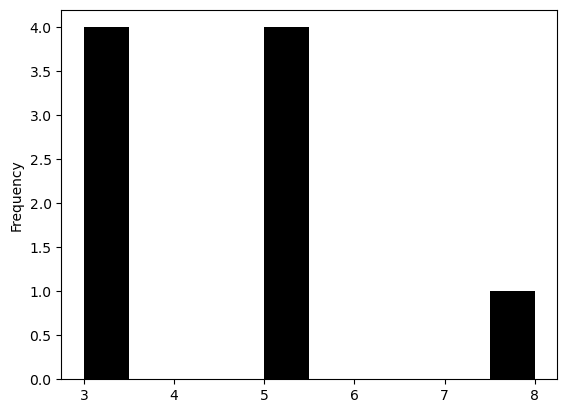

In [15]:
pandas.Series(wq.cardinalities).plot.hist(color="k");

Los atributos `cardinalities` y `histogram` permiten identificar **asimetrías** en el número de vecinos por observación. Esto es importante en análisis espaciales como la **autocorrelación** o la **regresión espacial**.

Por ejemplo, en una cuadrícula 3x3:
- Las esquinas tienen 3 vecinos,
- Los bordes, 5 vecinos,
- Y el centro, 8 vecinos.
No hay unidades con 4, 6 o 7 vecinos.

Por convención, cada par ordenado de vecinos se representa como un **enlace** con peso distinto de cero. El atributo `s0` indica el **número total de enlaces** en el objeto $W$.

In [16]:
wq.s0

np.float64(40.0)

En este caso, los pesos tipo **Queen** casi duplican el número de enlaces comparados con los de tipo Rook.

El atributo `pct_nonzero` indica la **densidad** de la matriz de pesos espaciales, es decir, el porcentaje de entradas diferentes de cero (si se almacenara la matriz completa).

In [17]:
wq.pct_nonzero

49.382716049382715

Las medidas originales de dependencia propuestas por Moran y Geary se basaban en contiguidad binaria entre unidades espaciales.

> Si dos unidades espaciales tienen un *borde común* de longitud no nula, se consideran contiguos, y se asigna el valor $1$.

Esta definición obviamente asume la existencia de un mapa del que los bordes pueden discernirse. Sin embargo, cuando se ubican en un *grid*, **la contiguidad no es única**. 

Por ejemplo, considere la siguiente figura con sus respectivos centroides:

<img src="images/Contiguidad.png" width="700" height="700">


Un *borde común* entre la celda $a$ y celdas aledañas puede considerarse de diferentes maneras. Por ejemplo:

-   Si se toma el criterio del **lado común** (*common edge*), las celdas $b$ son contiguas. Análogo al movimiento de la **torre** en ajedrez (*rook case*).
-   Si se toma el criterio de **vértice común** (*common vertex*), entonces las celdas $c$ son contiguas. Análogo al movimiento del **alfil** en ajedrez (*bishop case*).
-   Una combinación de las dos, donde las celdas $b$ y $c$ resultan contiguas. Análogo al movimiento de la **reina** en ajedrez (*queen case*).
-   Criterio del camino más corto como criterio de contigüidad  (*radius*). Los puntos se consideran vecinos si están dentro de un determinado radio o distancia uno de otro. Los puntos $B$ están dentro del radio $d$ del centroide $A$ se pueden considerar vecinos de $A$.


También se puede considerar *órdenes de contiguidad*. Esto se logra de manera recursiva:

-   definiendo el orden de contigüidad $k$-ésimo cuando las unidades espaciales son contiguas de primer orden a la unidad espacial de orden $(k-1)$-ésimo. 

En un grid cuadrado, esto es una serie de bandas concéntricas alrededor de la unidad espacial en consideración. Por ejemplo: las celdas $c$ y $d$ son contiguas de segundo orden a $a$ de acuerdo al criterio de la torre, porque $c$ y $d$ son contiguos de primer orden a $b$.


La estructura espacial resultante se expresa formalmente en una matriz de contiguidad o conectividad. Esta matriz tiene tantas filas y columnas como unidades espaciales existan. En cada fila, una columna distinta de cero corresponde a unidades espaciales contiguas. 

Por ejemplo, las 9 celdas en el centro de la figura anterior (numeradas de izquierda a derecha y de arriba hacia abajo) se presenta en la siguiente tabla usando el criterio de la torre. 

<img src="images/torreCont.png" width="700" height="180">

Claramente, el tener varias formas de definir contiguidad no es una cualidad deseable:

-   Es una representación limitada de las posibles interacciones espaciales que pueden formularse.
-   La misma matriz de contigüidad puede representar varios arreglos de unidades espaciales.

#### Matrices de pesos espaciales


<!-- pagina 19 -->

La idea de contiguidad binaria fue extendida para incluir interacciones potenciales entre dos unidades espaciales. La determinación de una especificación apropiada para esta matriz, $w_{ij}$, es uno de los temas metodológicos más difíciles y controversiales en econometría espacial.


La sugerencia original de Cliff y Ord consiste en usar una combinación medidas de distancia (distancia inversa, o exponenciales negativos de la distancia) y la longitud relativa del borde común entre dos unidades espaciales, en el sentido del **porcentaje en el total de la longitud del borde que es ocupado por la otra unidad en consideración**. 


<img src="images/wijCO.png" width="700" height="700">


Los pesos resultantes serán asimétricos, a menos que ambas unidades espaciales tengan la misma longitud de borde. Formalmente.

$$
w_{ij} = [d_{ij}]^{-a}[\beta_{ij}]^{b}
$$


con $d_{ij}$ como la distancia entre la unidad espacial $i$ y $j$, $\beta_{ij}$ como la proporción del borde de la unidad $i$ que está en contacto con la unidad $j$, y $a$ y $b$ como parámetros. 


De manera similar, Dacey sugirió pesos que también toman en cuenta el área relativa de las unidades espaciales:

$$
w_{ij} = d_{ij}\alpha_{i}\beta_{ij}
$$

con $d_{ij}$ como un factor binario de contigüidad, $\alpha_i$ como el porcentaje de la unidad espacial $i$ sobre el **total de todas las unidades espaciales** en el sistema, y $\beta_{ij}$ como la medida de borde usada antes.

Ambos pesos están estrechamente vinculados a las características físicas de las unidades espaciales en un mapa. Al igual que con las medidas de contigüidad binaria, son **menos útiles cuando las unidades espaciales consisten en puntos**, ya que entonces las nociones de longitud y área del borde son en gran medida artificiales y están determinadas por un [algoritmo de teselación](https://es.wikipedia.org/wiki/Teselaci%C3%B3n_(inform%C3%A1tica)) particular. También son menos significativos cuando el fenómeno de interacción espacial en consideración está determinado por factores tales como **variables puramente económicas, que pueden tener poco que ver con la configuración espacial de los límites en un mapa físico**.

En este sendito, por ejemplo Bodson y Peeters proponen unos pesos de accesibilidad (calibrados entre 0 y 1), que combina en una función logística la influencia de varios canales de comunicación entre unidades espaciales, como carreteras, tren, y otros enlaces de comunicación. Formalmente,

$$
w_{ij} = \sum_jk_j\left(\frac{a}{1+be^{-c_jd_{ij}}}\right)
$$
donde $k_j$ muestra la importancia relativa del medio de comunicación $j$. La suma es sobre los $j$ medios de comunicación, que separan las unidades espaciales por una distancia $d_{ij}$. $a$, $b$ y $c_j$ son parámtros a estimarse. 


En la mayoría de las aplicaciones de la ciencia regional, la matriz de ponderaciones se basa en alguna **combinación de relaciones de distancia y contigüidad simple**. Las distancias involucradas son en el sentido más general y pueden basarse en el tiempo de viaje, o derivarse de un análisis de escala multidimensional. En la mayoría de las aplicaciones sociológicas del análisis espacial, la matriz de peso está determinada por **conceptos de la teoría de redes sociales**.


Un problema importante resulta de la incorporación de **parámetros en los pesos**. Normalmente, estos pesos se consideran **exógenos y los valores de los parámetros se determinan a priori, o en un paso separado del resto del análisis espacial**. Esto crea problemas para la estimación e interpretación de los resultados. En particular, podría conducir potencialmente a la **inferencia de relaciones espurias**, ya que la validez de las estimaciones está condicionada previamente por la medida en que la estructura espacial se refleja correctamente en las ponderaciones. Más importante aún, **podría resultar en un razonamiento circular**, en el que la estructura espacial, que el analista puede desear descubrir en los datos, debe suponerse conocida antes de llevar a cabo el análisis de datos. 
En el contexto de **pruebas de hipótesis**, dado que la hipótesis nula es de independencia espacial, la matriz de ponderaciones debe relacionarse con la hipótesis alternativa relevante de dependencia espacial, con el fin de maximizar la potencia de la prueba. Sin embargo, incluso con una matriz de ponderación especificada incorrectamente, **el rechazo de la hipótesis nula solo implicará una falta de independencia, y no un tipo particular de dependencia**. Aunque la potencia de la prueba se verá afectada, la posibilidad de conclusiones falsas no es tan grande **como en la especificación funcional de un modelo**.

#### Operadores de rezago espacial

El objetivo del uso de una matriz de ponderación espacial en la especificación de modelos econométricos espaciales es **relacionar una variable en un punto del espacio con las observaciones de esa variable en otras unidades espaciales del sistema**. 

En un contexto de series de tiempo, esto se logra mediante el uso de un operador de retardo o rezago, que desplaza la variable en uno o más períodos en el tiempo. Por ejemplo:


$$
y_{t-k} = L^ky
$$
muestra la variable $y$ rezagada $k$ periodos desde $t$, como la potencia $k$-ésima del operador de rezagos $L$.

En el espacio, debido a las infinitas direcciones que se puede girar, las cosas se complican. Por ejemplo, considere la siguiente figura:


<img src="images/lag.png" width="700" height="700">

La variable $x$ observada en la posición $i,j$ puede girarse de las siguientes maneras:

-   usando el criterio de la torre:

$$
x_{i-1,j};x_{i,j-1};x_{i+1,j};x_{i,j+1};
$$

-   usando el criterio del alfil:

$$
x_{i-1,j-1};x_{i+1,j-1};x_{i+1,j+1};x_{i-1,j+1};
$$

Para el criterio de la reina se tiene 8 posibles movimientos. 

En las aplicaciones no suele existir una justificación apriori para guiar la elección de la dependencia. Además, si es un *grid* irregular las posibilidades son infinitas y el número de grados de libertad disponibles pueden ser insuficientes para tener estimaciones eficientes. 


Este problema se resuelve considerando una suma ponderada de todos los valores que pertenecen a una clase de contigüidad, en lugar de tomarlos de manera individual. Los términos de la suma se obtienen multiplicando las observaciones por el peso asociado de la matriz de pesos espaciales. Formalmente:

$$
L^sx_i = \sum_jw_{ij}x_{j} \quad \forall j \in J_i
$$


donde $L^s$ es el operador de rezago asociado con la clase de contigüidad $s$ para $i$, y $w_{ij}$ son las ponderaciones espaciales. En notación matricial:

$$
L^sx = W_{s}x.
$$


Los pesos $w_{ij}$ se consideran como dados, pero estimar los pesos y la asociación estadísitica en conjunto se vuelve un problema no lineal. Al fijarlos previamente el problema es lineal. 

Un rezago espacial menos restrictivo puede construirse de la noción de accesibilidad potencial, como:

$$
f_i = \sum_jq(d_{ij},\theta)x_j
$$


donde $f_i$ es el potencial en $i$, y $q$ es una función de distancia $d_{ij}$ entre $i$ y $j$, parametrizada en términos de un vector de coeficientes $\theta$. Dado que la expresión resultante es no lineal, la estimación y las pruebas de hipótesis pueden ser más complejas. 


## Ejercicio

Usando la siguiente figura, debes:

<img src="images/pesosTarea.png" width="700" height="700">

1. Representar la matriz de pesos espaciales bajo el criterio de contiguidad.
2. Estandarizar por filas la matriz de pesos espacilaes.
3. Revisa y comenta la simetría de la matriz en el paso 1 y en el paso 2.

## Pesos espaciales en datos geográficos reales

Aunque los ejemplos con cuadrículas regulares ayudan a comprender la lógica de los pesos espaciales en `pysal`, su aplicación real implica trabajar con datos geográficos concretos.

`pysal` permite construir objetos de pesos espaciales a partir de formatos comunes como **shapefiles**, los cuales no incluyen explícitamente las relaciones de vecindad. Por ello, estas deben **derivarse manualmente**, y `pysal` facilita este proceso mediante estructuras de **indexación espacial** eficientes.

En este caso, se demostrará cómo construir pesos espaciales usando las **provincias del Ecuador** como unidades geográficas de análisis. Fuente de datos: https://www.ecuadorencifras.gob.ec/documentos/web-inec/Geografia_Estadistica/Micrositio_geoportal/index.html



In [18]:
import requests
from io import BytesIO
import zipfile
import geopandas as gpd

# 1. Descargar shapefile directamente desde GitHub
url = "https://github.com/vmoprojs/DataLectures/raw/master/SpatialData/SHP.zip"
response = requests.get(url)
zip_bytes = BytesIO(response.content)

# 2. Extraer y leer el shapefile
with zipfile.ZipFile(zip_bytes, "r") as z:
    shp_name = [f for f in z.namelist() if f.endswith("nxprovincias.shp")][0]
    z.extractall("tmp_shapefile")
    gdf = gpd.read_file("tmp_shapefile/" + shp_name)

# 3. Reproyección a Web Mercator para usar contextily
gdf = gdf.to_crs(epsg=3857)

In [19]:
w_queen = weights.contiguity.Queen.from_dataframe(gdf,use_index=True)

/opt/anaconda3/envs/geo_env/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 19.
  W.__init__(self, neighbors, ids=ids, **kw)


El warning nos advierte que tenemos una isla desconectada: Galápagos. Podemos omitirla de la siguiente manera:

In [20]:
# Obtener la lista de IDs que no tienen vecinos (islas)
islas = w_queen.islands
print("Islas detectadas:", islas)

Islas detectadas: [19]


In [21]:
# Filtrar el GeoDataFrame y excluir las islas
gdf_sin_islas = gdf[~gdf.index.isin(islas)].copy()


In [22]:
w_queen_sin_islas = weights.contiguity.Queen.from_dataframe(gdf_sin_islas,use_index=True)

(np.float64(-9026177.003082927),
 np.float64(-8370004.833131398),
 np.float64(-559048.7630201177),
 np.float64(164011.29605926413))

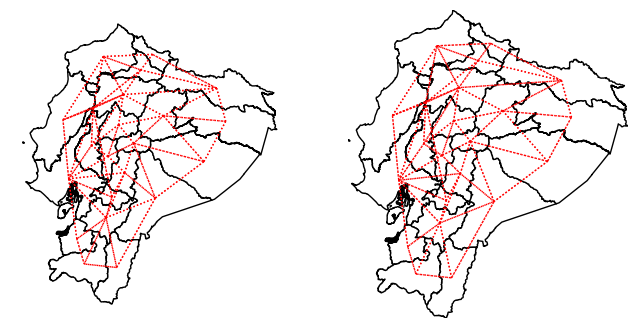

In [23]:
# Crea una figura con 2 subgráficos (1 fila, 2 columnas)
# figsize=(8, 4) define el tamaño total de la figura (ancho x alto en pulgadas)
f, axs = plt.subplots(1, 2, figsize=(8, 4))

# Itera sobre los dos subgráficos (ax[0] y ax[1])
for i in range(2):
    # Dibuja los polígonos del GeoDataFrame sin islas (gdf_sin_islas)
    # edgecolor="k": bordes negros
    # facecolor="w": relleno blanco
    ax = gdf_sin_islas.plot(edgecolor="k", facecolor="w", ax=axs[i])
    
    # Dibuja las conexiones de vecindad sobre el mismo gráfico
    # edge_kws define el estilo de las líneas (rojas, punteadas, grosor 1)
    # node_kws define la apariencia de los nodos; marker="" implica que no se dibujan símbolos de nodo
    w_queen_sin_islas.plot(
        gdf_sin_islas,
        ax=axs[i],
        edge_kws=dict(color="r", linestyle=":", linewidth=1),
        node_kws=dict(marker=""),
    )

    # Elimina los ejes (ticks, etiquetas, etc.) para una visualización más limpia
    axs[i].set_axis_off()

# En el segundo subgráfico (axs[1]), fija manualmente los límites del área visible del gráfico
# Esto puede ser útil si deseas hacer zoom o asegurar una escala fija (xmin, ymin, xmax, ymax )

# Obtener límites espaciales automáticamente del GeoDataFrame
xmin, ymin, xmax, ymax = gdf_sin_islas.total_bounds

axs[1].axis([xmin, xmax, ymin, ymax])


El objeto de pesos espaciales construido para las **provincias del Ecuador** posee los mismos **atributos y métodos** que se observaron previamente con la cuadrícula artificial. Esto incluye información sobre vecinos, pesos, cardinalidades, densidad, entre otros, lo que permite aplicar técnicas de análisis espacial de forma consistente.


In [24]:
print(w_queen.n)
print(w_queen.pct_nonzero)

23
20.793950850661627


Al trabajar con las **provincias del Ecuador**, se observa un **mayor número de unidades espaciales** en comparación con la cuadrícula de ejemplo. Esto da lugar a una **matriz de pesos más dispersa**.

Además, la **distribución de cardinalidades** (número de vecinos por unidad) es significativamente distinta, reflejando la **complejidad y heterogeneidad geográfica** del territorio real.

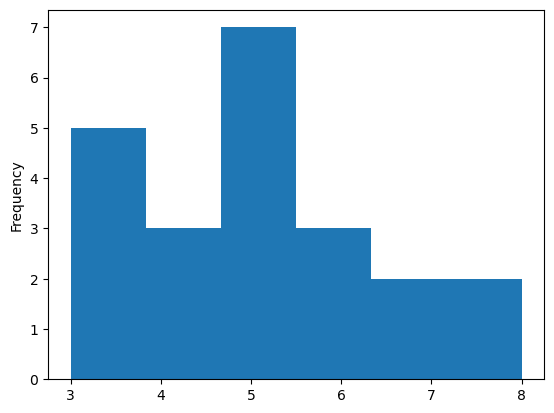

In [25]:
s = pandas.Series(w_queen_sin_islas.cardinalities)
s.plot.hist(bins=s.unique().shape[0]);

## Ejercicio

Realiza el mismo ejercicio de provincias, pero ahora con los cantones de Ecuador.

### Pesos espaciales basados en k vecinos más cercanos

Una forma de definir pesos espaciales basados en distancia es mediante los **k vecinos más cercanos**. Cada unidad se conecta con sus **k observaciones más próximas**, donde


In [26]:
wk4 = weights.distance.KNN.from_dataframe(gdf, k=4)

Los **centroides** se obtienen a partir de la geometría almacenada en el `GeoDataFrame`. En el caso de polígonos, `pysal` utiliza las **distancias entre centroides** para identificar los **k vecinos más cercanos**.

Una ventaja de este método es que **no existen unidades aisladas**: cada observación tiene al menos un vecino garantizado.

In [27]:
wk4.islands

[]

Al igual que con los pesos por contigüidad, los pesos de **k vecinos más cercanos** aseguran que todas las unidades tengan vecinos. Sin embargo, en este caso, eso se garantiza **por construcción**.

Además, al observar el histograma de cardinalidades, se puede notar otra propiedad clave: **todas las observaciones tienen exactamente k vecinos**, lo que otorga uniformidad a la estructura de la matriz de pesos.


In [28]:
wk4.histogram

[(np.int64(4), np.int64(23))]